In [ ]:
%pip install -U pip
%pip install -U mealpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 69.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 48.8 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [mealpy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incomp

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 67.3 MB/s  0:00:01


In [ ]:
import os
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV

from mealpy.utils.space import FloatVar
from mealpy.bio_based import TSA



os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(42)
random.seed(42)

In [ ]:
 !gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju

Downloading...
From: https://drive.google.com/uc?id=16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju
To: /content/cleveland.csv
100% 10.9k/10.9k [00:00<00:00, 32.0MB/s]


In [ ]:
DATA_PATH = 'cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

K_features = 10
raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
  raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] >0).astype(int)
print('Shape:', raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (303, 14)


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  target  
0  0.0   6.0       0  
1  3.0   3.0       1  
2  2.0   7.0       1  
3  0.0   3.0       0  
4  0.0   3.0       0

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

In [ ]:
TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]
X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
print(y_all.value_counts())
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

target
0    164
1    139
Name: count, dtype: int64
target
0    131
1    111
Name: count, dtype: int64
target
0    16
1    14
Name: count, dtype: int64
target
0    17
1    14
Name: count, dtype: int64


In [ ]:
cat_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
num_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_proc, numeric_cols),
    ('cat', cat_proc, categorical_cols),
])

raw_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
])

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
  if hasattr(transformer, 'get_feature_names_out'):
    preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
  else:
    preprocessed_feature_names.extend(columns)

X_raw_train_df = pd.DataFrame(
    X_raw_train,
    columns=preprocessed_feature_names,
    index=X_train.index
)
X_raw_val_df = pd.DataFrame(
    X_raw_val,
    columns=preprocessed_feature_names,
    index=X_val.index
)
X_raw_test_df = pd.DataFrame(
    X_raw_test,
    columns=preprocessed_feature_names,
    index=X_test.index
)

out_dir = Path('splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'raw_test.csv', index=False)

display(X_raw_train_df.head())

age  trestbps      chol   thalach   oldpeak  sex_0.0  sex_1.0  \
180 -0.729485 -0.395692  0.458139  0.708371 -0.445445      0.0      1.0   
208  0.050166 -0.054513  0.230598  0.222495 -0.891627      0.0      1.0   
167 -0.061212  0.059213  0.723605  0.399178 -0.891627      1.0      0.0   
105 -0.061212 -1.305501  1.121803  0.266666 -0.891627      0.0      1.0   
297  0.272924  0.514117 -0.167601 -1.190962 -0.713154      1.0      0.0   

     cp_1.0  cp_2.0  cp_3.0  ...  slope_1.0  slope_2.0  slope_3.0  ca_0.0  \
180     0.0     0.0     0.0  ...        0.0        1.0        0.0     1.0   
208     0.0     1.0     0.0  ...        1.0        0.0        0.0     1.0   
167     0.0     1.0     0.0  ...        1.0        0.0        0.0     0.0   
105     0.0     1.0     0.0  ...        1.0        0.0        0.0     1.0   
297     0.0     0.0     0.0  ...        0.0        1.0        0.0     1.0   

     ca_1.0  ca_2.0  ca_3.0  thal_3.0  thal_6.0  thal_7.0  
180     0.0     0.0     0.0       0.0       0.0       1.0  
208     0.0     0.0     0.0       1.0       0.0       0.0  
167     1.0     0.0     0.0       1.0       0.0       0.0  
105     0.0     0.0     0.0       0.0       0.0       1.0  
297     0.0     0.0     0.0       0.0       0.0       1.0  

[5 rows x 28 columns]

In [ ]:
df_feature_selection_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

df_feature_selection_pipeline.fit(X_train, y_train)
feature_importance_series = pd.Series(
    df_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=preprocessed_feature_names
)

sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
display(sorted_feature_importances)

selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

X_dt_train = X_raw_train_df[selected_features]
X_dt_val = X_raw_val_df[selected_features]
X_dt_test = X_raw_test_df[selected_features]
display(X_dt_train.head())

pd.concat([X_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_train.csv', index=False)
pd.concat([X_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_val.csv', index=False)
pd.concat([X_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'dt_test.csv', index=False)

thal_3.0       0.292921
cp_4.0         0.119427
chol           0.110055
oldpeak        0.107935
ca_0.0         0.097622
age            0.096128
sex_0.0        0.033909
trestbps       0.027639
cp_3.0         0.019416
thalach        0.018673
fbs_0.0        0.016444
slope_1.0      0.016138
exang_1.0      0.015216
ca_1.0         0.014265
restecg_0.0    0.008321
cp_2.0         0.005890
thal_6.0       0.000000
slope_3.0      0.000000
ca_3.0         0.000000
ca_2.0         0.000000
restecg_1.0    0.000000
slope_2.0      0.000000
exang_0.0      0.000000
restecg_2.0    0.000000
fbs_1.0        0.000000
cp_1.0         0.000000
sex_1.0        0.000000
thal_7.0       0.000000
dtype: float64

Top 10 selected features: ['thal_3.0', 'cp_4.0', 'chol', 'oldpeak', 'ca_0.0', 'age', 'sex_0.0', 'trestbps', 'cp_3.0', 'thalach']


thal_3.0  cp_4.0      chol   oldpeak  ca_0.0       age  sex_0.0  \
180       0.0     1.0  0.458139 -0.445445     1.0 -0.729485      0.0   
208       1.0     0.0  0.230598 -0.891627     1.0  0.050166      0.0   
167       1.0     0.0  0.723605 -0.891627     0.0 -0.061212      1.0   
105       0.0     0.0  1.121803 -0.891627     1.0 -0.061212      0.0   
297       0.0     1.0 -0.167601 -0.713154     1.0  0.272924      1.0   

     trestbps  cp_3.0   thalach  
180 -0.395692     0.0  0.708371  
208 -0.054513     0.0  0.222495  
167  0.059213     0.0  0.399178  
105 -1.305501     0.0  0.266666  
297  0.514117     0.0 -1.190962

In [ ]:
def add_new_features_func(df):
  df = df.copy()
  if {'chol', 'age'} <= set(df.columns):
    df['chol_per_age'] = df['chol'] / df['age']
  if {'trestbps', 'age'} <= set(df.columns):
    df['bps_per_age'] = df['trestbps'] / df['age']
  if {'thalach', 'age'} <= set(df.columns):
    df['hr_ratio'] = df['thalach'] / df['age']
  if 'age' in df.columns:
    df['age_bin'] = pd.cut(
        df['age'], bins=5, labels=False
    ).astype('category')
  return df

class AddNewFeaturesTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, X, y=None):
    self.columns_ = X.columns
    self.new_features_ = []
    if {'chol', 'age'} <= set(X.columns):
      self.new_features_.append('chol_per_age')
    if {'trestbps', 'age'} <= set(X.columns):
      self.new_features_.append('bps_per_age')
    if {'thalach', 'age'} <= set(X.columns):
      self.new_features_.append('hr_ratio')
    if 'age' in X.columns:
      self.new_features_.append('age_bin')
    return self

  def transform(self, X, y=None):
    return add_new_features_func(X)

  def get_feature_names_out(self, input_features=None):
    return list(self.columns_) + self.new_features_

gen_num = ['chol_per_age', 'bps_per_age', 'hr_ratio']
gen_cat = ['age_bin']
all_nums = [c for c in numeric_cols] + gen_num
all_cats = [c for c in categorical_cols] + gen_cat

num_proc = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc', StandardScaler())])
cat_proc = Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([
    ('num', num_proc, all_nums),
    ('cat', cat_proc, all_cats),
], verbose_feature_names_out=False).set_output(transform='pandas')
fe_pre = Pipeline([
    ('add_new_features', AddNewFeaturesTransformer()),
    ('pre', pre),
]).set_output(transform='pandas')

Xt_tr = fe_pre.fit_transform(X_train, y_train)
Xt_va = fe_pre.transform(X_val)
Xt_te = fe_pre.transform(X_test)

nz_cols = Xt_tr.columns[Xt_tr.nunique(dropna=False) > 1]
Xt_tr = Xt_tr[nz_cols]
Xt_va = Xt_va[nz_cols]
Xt_te = Xt_te[nz_cols]

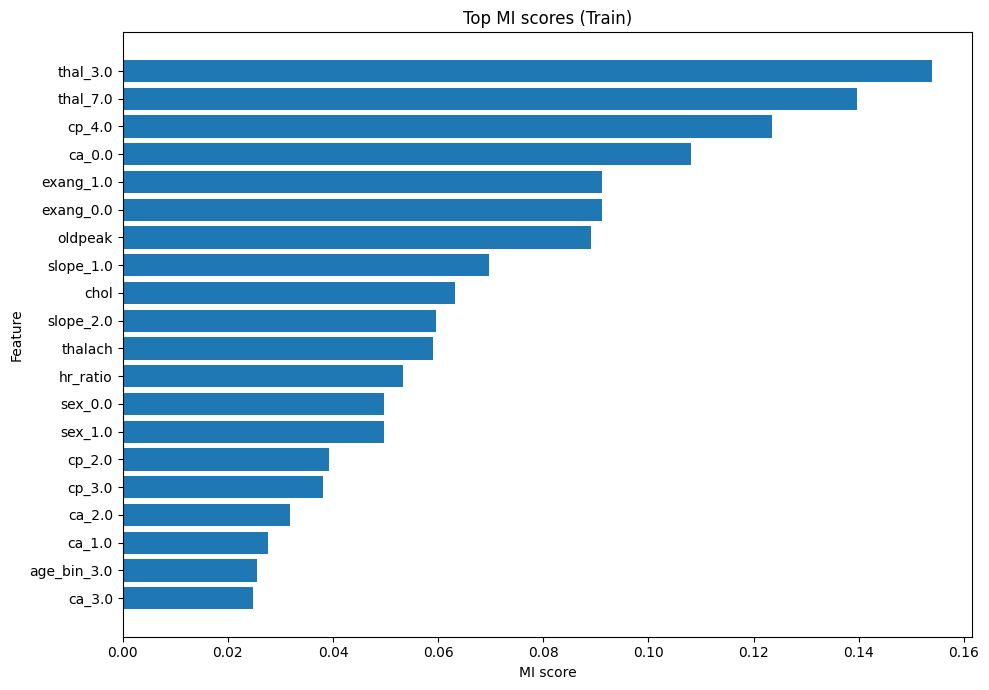

0      thal_3.0
1      thal_7.0
2        cp_4.0
3        ca_0.0
4     exang_1.0
5     exang_0.0
6       oldpeak
7     slope_1.0
8          chol
9     slope_2.0
10      thalach
11     hr_ratio
12      sex_0.0
Name: fe_topk_features, dtype: object

In [ ]:
ohe = fe_pre.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_names = list(ohe.get_feature_names_out(all_cats))
is_discrete = np.array(
    [c in cat_names for c in Xt_tr.columns],
    dtype = bool
)
mi = mutual_info_classif(Xt_tr.values, y_train.values,
                         discrete_features=is_discrete,
                         random_state=42)
mi_series = pd.Series(mi, index=Xt_tr.columns).sort_values(ascending=False)

N = min(20, len(mi_series))
topN = mi_series.head(N).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*N)))
plt.barh(topN.index, topN.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('top_mi_scores.pdf', bbox_inches='tight')
plt.show()

K= raw.columns.drop('target').shape[0]
topk_cols = list(mi_series.head(K).index)
fe_tr = Xt_tr[topk_cols].assign(target=y_train.values)
fe_va = Xt_va[topk_cols].assign(target=y_val.values)
fe_te = Xt_te[topk_cols].assign(target=y_test.values)

out = Path('splits'); out.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out / 'fe_train.csv', index=False)
fe_va.to_csv(out / 'fe_val.csv', index=False)
fe_te.to_csv(out / 'fe_test.csv', index=False)

display(pd.Series(
    topk_cols, name='fe_topk_features'
).reset_index(drop=True))

In [ ]:
dt_fe_feature_selection_pipeline = Pipeline([
    ('preprocess', fe_pre),
    ('decision_tree', DecisionTreeClassifier(random_state=42))
])

dt_fe_feature_selection_pipeline.fit(X_train, y_train)
pipeline_feature_names = dt_fe_feature_selection_pipeline.named_steps['preprocess'].get_feature_names_out()

feature_importance_series = pd.Series(
    dt_fe_feature_selection_pipeline.named_steps['decision_tree'].feature_importances_,
    index=pipeline_feature_names
)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

selected_features = sorted_feature_importances.head(K_features).index.tolist()
print(f'Top {K_features} selected features: {selected_features}')

X_fe_dt_train = Xt_tr[selected_features]
X_fe_dt_val = Xt_va[selected_features]
X_fe_dt_test = Xt_te[selected_features]
display(X_fe_dt_train.head())

pd.concat([X_fe_dt_train, y_train.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_train.csv', index=False)
pd.concat([X_fe_dt_val, y_val.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_val.csv', index=False)
pd.concat([X_fe_dt_test, y_test.rename(TARGET)],
          axis=1).to_csv(out_dir / 'fe_dt_test.csv', index=False)

Top 10 selected features: ['thal_3.0', 'cp_4.0', 'ca_0.0', 'chol_per_age', 'hr_ratio', 'oldpeak', 'chol', 'age', 'exang_0.0', 'cp_3.0']


thal_3.0  cp_4.0  ca_0.0  chol_per_age  hr_ratio   oldpeak      chol  \
180       0.0     1.0     1.0      0.952258  0.726265 -0.445445  0.458139   
208       1.0     0.0     1.0      0.082082 -0.054469 -0.891627  0.230598   
167       1.0     0.0     0.0      0.606839  0.099522 -0.891627  0.723605   
105       0.0     0.0     1.0      0.965051  0.031766 -0.891627  1.121803   
297       0.0     1.0     1.0     -0.411237 -0.859761 -0.713154 -0.167601   

          age  exang_0.0  cp_3.0  
180 -0.729485        1.0     0.0  
208  0.050166        1.0     0.0  
167 -0.061212        0.0     0.0  
105 -0.061212        1.0     0.0  
297  0.272924        0.0     0.0

In [ ]:
!zip -r dataset.zip splits


  adding: splits/ (stored 0%)
  adding: splits/raw_val.csv (deflated 74%)
  adding: splits/fe_train.csv (deflated 74%)
  adding: splits/fe_val.csv (deflated 64%)
  adding: splits/raw_train.csv (deflated 84%)
  adding: splits/dt_val.csv (deflated 63%)
  adding: splits/dt_train.csv (deflated 78%)
  adding: splits/dt_test.csv (deflated 63%)
  adding: splits/fe_dt_test.csv (deflated 60%)
  adding: splits/raw_test.csv (deflated 74%)
  adding: splits/fe_test.csv (deflated 63%)
  adding: splits/fe_dt_val.csv (deflated 61%)
  adding: splits/fe_dt_train.csv (deflated 69%)


In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
def read_csv(file_path):
  df = pd.read_csv(file_path)
  display(df.head())
  X = df.drop(TARGET, axis=1)
  y = df[TARGET]
  display(y.value_counts())

  print('Shape df:', df.shape)
  print('Shape X:', X.shape)
  print('Shape y:', y.shape)

  return X,y

In [ ]:

#Original Dataset
X_train, y_train = read_csv('splits/raw_train.csv')
X_val, y_val = read_csv('splits/raw_val.csv')
X_test, y_test = read_csv('splits/raw_test.csv')

#FE Dataset
X_fe_train, y_fe_train = read_csv('splits/fe_train.csv')
X_fe_val, y_fe_val = read_csv('splits/fe_val.csv')
X_fe_test, y_fe_test = read_csv('splits/fe_test.csv')

#Original + DT Dataset
X_dt_train, y_dt_train = read_csv('splits/dt_train.csv')
X_dt_val, y_dt_val = read_csv('splits/dt_val.csv')
X_dt_test, y_dt_test = read_csv('splits/dt_test.csv')

#FE + DT Dataset
X_fe_dt_train, y_fe_dt_train = read_csv('splits/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('splits/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('splits/fe_dt_test.csv')

age  trestbps      chol   thalach   oldpeak  sex_0.0  sex_1.0  cp_1.0  \
0 -0.729485 -0.395692  0.458139  0.708371 -0.445445      0.0      1.0     0.0   
1  0.050166 -0.054513  0.230598  0.222495 -0.891627      0.0      1.0     0.0   
2 -0.061212  0.059213  0.723605  0.399178 -0.891627      1.0      0.0     0.0   
3 -0.061212 -1.305501  1.121803  0.266666 -0.891627      0.0      1.0     0.0   
4  0.272924  0.514117 -0.167601 -1.190962 -0.713154      1.0      0.0     0.0   

   cp_2.0  cp_3.0  ...  slope_2.0  slope_3.0  ca_0.0  ca_1.0  ca_2.0  ca_3.0  \
0     0.0     0.0  ...        1.0        0.0     1.0     0.0     0.0     0.0   
1     1.0     0.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
2     1.0     0.0  ...        0.0        0.0     0.0     1.0     0.0     0.0   
3     1.0     0.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
4     0.0     0.0  ...        1.0        0.0     1.0     0.0     0.0     0.0   

   thal_3.0  thal_6.0  thal_7.0  target  
0       0.0       0.0       1.0       1  
1       1.0       0.0       0.0       0  
2       1.0       0.0       0.0       0  
3       0.0       0.0       1.0       0  
4       0.0       0.0       1.0       1  

[5 rows x 29 columns]

target
0    131
1    111
Name: count, dtype: int64

Shape df: (242, 29)
Shape X: (242, 28)
Shape y: (242,)


age  trestbps      chol   thalach   oldpeak  sex_0.0  sex_1.0  cp_1.0  \
0 -1.063621  0.400391 -0.262410  0.089984 -0.713154      1.0      0.0     0.0   
1  1.720848 -0.054513  1.368307 -1.809349  1.250048      0.0      1.0     0.0   
2 -0.061212  1.082748 -0.338257  0.664201  0.536156      0.0      1.0     0.0   
3  0.941197  0.229802  0.040979  0.973394 -0.891627      1.0      0.0     0.0   
4  0.495681  0.229802 -0.300333  0.487519 -0.445445      0.0      1.0     0.0   

   cp_2.0  cp_3.0  ...  slope_2.0  slope_3.0  ca_0.0  ca_1.0  ca_2.0  ca_3.0  \
0     0.0     0.0  ...        1.0        0.0     1.0     0.0     0.0     0.0   
1     0.0     0.0  ...        1.0        0.0     0.0     0.0     0.0     1.0   
2     0.0     1.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
3     0.0     1.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
4     0.0     0.0  ...        1.0        0.0     1.0     0.0     0.0     0.0   

   thal_3.0  thal_6.0  thal_7.0  target  
0       1.0       0.0       0.0       0  
1       1.0       0.0       0.0       1  
2       0.0       0.0       1.0       0  
3       1.0       0.0       0.0       0  
4       0.0       0.0       1.0       0  

[5 rows x 29 columns]

target
0    16
1    14
Name: count, dtype: int64

Shape df: (30, 29)
Shape X: (30, 28)
Shape y: (30,)


age  trestbps      chol   thalach   oldpeak  sex_0.0  sex_1.0  cp_1.0  \
0  0.384303 -0.168240 -0.641646 -0.837597  1.071575      0.0      1.0     0.0   
1 -2.288787 -0.736870 -1.286348  1.061736 -0.891627      0.0      1.0     1.0   
2  0.829818 -0.054513 -0.357219 -0.175039  0.714629      0.0      1.0     0.0   
3 -0.395349 -0.054513  0.116827 -0.042528 -0.445445      1.0      0.0     0.0   
4 -1.397757 -0.623144 -0.186562  1.945146 -0.177735      0.0      1.0     0.0   

   cp_2.0  cp_3.0  ...  slope_2.0  slope_3.0  ca_0.0  ca_1.0  ca_2.0  ca_3.0  \
0     0.0     0.0  ...        1.0        0.0     0.0     0.0     0.0     1.0   
1     0.0     0.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
2     0.0     1.0  ...        1.0        0.0     0.0     0.0     0.0     1.0   
3     0.0     1.0  ...        0.0        0.0     1.0     0.0     0.0     0.0   
4     0.0     1.0  ...        0.0        1.0     1.0     0.0     0.0     0.0   

   thal_3.0  thal_6.0  thal_7.0  target  
0       0.0       0.0       1.0       1  
1       1.0       0.0       0.0       0  
2       0.0       0.0       1.0       0  
3       1.0       0.0       0.0       0  
4       0.0       0.0       1.0       0  

[5 rows x 29 columns]

target
0    17
1    14
Name: count, dtype: int64

Shape df: (31, 29)
Shape X: (31, 28)
Shape y: (31,)


thal_3.0  thal_7.0  cp_4.0  ca_0.0  exang_1.0  exang_0.0   oldpeak  \
0       0.0       1.0     1.0     1.0        0.0        1.0 -0.445445   
1       1.0       0.0     0.0     1.0        0.0        1.0 -0.891627   
2       1.0       0.0     0.0     0.0        1.0        0.0 -0.891627   
3       0.0       1.0     0.0     1.0        0.0        1.0 -0.891627   
4       0.0       1.0     1.0     1.0        1.0        0.0 -0.713154   

   slope_1.0      chol  slope_2.0   thalach  hr_ratio  sex_0.0  target  
0        0.0  0.458139        1.0  0.708371  0.726265      0.0       1  
1        1.0  0.230598        0.0  0.222495 -0.054469      0.0       0  
2        1.0  0.723605        0.0  0.399178  0.099522      1.0       0  
3        1.0  1.121803        0.0  0.266666  0.031766      0.0       0  
4        0.0 -0.167601        1.0 -1.190962 -0.859761      1.0       1

target
0    131
1    111
Name: count, dtype: int64

Shape df: (242, 14)
Shape X: (242, 13)
Shape y: (242,)


thal_3.0  thal_7.0  cp_4.0  ca_0.0  exang_1.0  exang_0.0   oldpeak  \
0       1.0       0.0     1.0     1.0        1.0        0.0 -0.713154   
1       1.0       0.0     1.0     0.0        0.0        1.0  1.250048   
2       0.0       1.0     0.0     1.0        0.0        1.0  0.536156   
3       1.0       0.0     0.0     1.0        0.0        1.0 -0.891627   
4       0.0       1.0     1.0     1.0        0.0        1.0 -0.445445   

   slope_1.0      chol  slope_2.0   thalach  hr_ratio  sex_0.0  target  
0        0.0 -0.262410        1.0  0.089984  0.628019      1.0       0  
1        0.0  1.368307        1.0 -1.809349 -1.592443      0.0       1  
2        1.0 -0.338257        0.0  0.664201  0.235034      0.0       0  
3        1.0  0.040979        0.0  0.973394 -0.161823      1.0       0  
4        0.0 -0.300333        1.0  0.487519 -0.163464      0.0       0

target
0    16
1    14
Name: count, dtype: int64

Shape df: (30, 14)
Shape X: (30, 13)
Shape y: (30,)


thal_3.0  thal_7.0  cp_4.0  ca_0.0  exang_1.0  exang_0.0   oldpeak  \
0       0.0       1.0     1.0     0.0        1.0        0.0  1.071575   
1       1.0       0.0     0.0     1.0        0.0        1.0 -0.891627   
2       0.0       1.0     0.0     0.0        0.0        1.0  0.714629   
3       1.0       0.0     0.0     1.0        0.0        1.0 -0.445445   
4       0.0       1.0     0.0     1.0        0.0        1.0 -0.177735   

   slope_1.0      chol  slope_2.0   thalach  hr_ratio  sex_0.0  target  
0        0.0 -0.641646        1.0 -0.837597 -0.736915      0.0       1  
1        1.0 -1.286348        0.0  1.061736  2.749978      0.0       0  
2        0.0 -0.357219        1.0 -0.175039 -0.619566      0.0       0  
3        1.0  0.116827        0.0 -0.042528  0.071622      1.0       0  
4        0.0 -0.186562        0.0  1.945146  2.141882      0.0       0

target
0    17
1    14
Name: count, dtype: int64

Shape df: (31, 14)
Shape X: (31, 13)
Shape y: (31,)


thal_3.0  cp_4.0      chol   oldpeak  ca_0.0       age  sex_0.0  trestbps  \
0       0.0     1.0  0.458139 -0.445445     1.0 -0.729485      0.0 -0.395692   
1       1.0     0.0  0.230598 -0.891627     1.0  0.050166      0.0 -0.054513   
2       1.0     0.0  0.723605 -0.891627     0.0 -0.061212      1.0  0.059213   
3       0.0     0.0  1.121803 -0.891627     1.0 -0.061212      0.0 -1.305501   
4       0.0     1.0 -0.167601 -0.713154     1.0  0.272924      1.0  0.514117   

   cp_3.0   thalach  target  
0     0.0  0.708371       1  
1     0.0  0.222495       0  
2     0.0  0.399178       0  
3     0.0  0.266666       0  
4     0.0 -1.190962       1

target
0    131
1    111
Name: count, dtype: int64

Shape df: (242, 11)
Shape X: (242, 10)
Shape y: (242,)


thal_3.0  cp_4.0      chol   oldpeak  ca_0.0       age  sex_0.0  trestbps  \
0       1.0     1.0 -0.262410 -0.713154     1.0 -1.063621      1.0  0.400391   
1       1.0     1.0  1.368307  1.250048     0.0  1.720848      0.0 -0.054513   
2       0.0     0.0 -0.338257  0.536156     1.0 -0.061212      0.0  1.082748   
3       1.0     0.0  0.040979 -0.891627     1.0  0.941197      1.0  0.229802   
4       0.0     1.0 -0.300333 -0.445445     1.0  0.495681      0.0  0.229802   

   cp_3.0   thalach  target  
0     0.0  0.089984       0  
1     0.0 -1.809349       1  
2     1.0  0.664201       0  
3     1.0  0.973394       0  
4     0.0  0.487519       0

target
0    16
1    14
Name: count, dtype: int64

Shape df: (30, 11)
Shape X: (30, 10)
Shape y: (30,)


thal_3.0  cp_4.0      chol   oldpeak  ca_0.0       age  sex_0.0  trestbps  \
0       0.0     1.0 -0.641646  1.071575     0.0  0.384303      0.0 -0.168240   
1       1.0     0.0 -1.286348 -0.891627     1.0 -2.288787      0.0 -0.736870   
2       0.0     0.0 -0.357219  0.714629     0.0  0.829818      0.0 -0.054513   
3       1.0     0.0  0.116827 -0.445445     1.0 -0.395349      1.0 -0.054513   
4       0.0     0.0 -0.186562 -0.177735     1.0 -1.397757      0.0 -0.623144   

   cp_3.0   thalach  target  
0     0.0 -0.837597       1  
1     0.0  1.061736       0  
2     1.0 -0.175039       0  
3     1.0 -0.042528       0  
4     1.0  1.945146       0

target
0    17
1    14
Name: count, dtype: int64

Shape df: (31, 11)
Shape X: (31, 10)
Shape y: (31,)


thal_3.0  cp_4.0  ca_0.0  chol_per_age  hr_ratio   oldpeak      chol  \
0       0.0     1.0     1.0      0.952258  0.726265 -0.445445  0.458139   
1       1.0     0.0     1.0      0.082082 -0.054469 -0.891627  0.230598   
2       1.0     0.0     0.0      0.606839  0.099522 -0.891627  0.723605   
3       0.0     0.0     1.0      0.965051  0.031766 -0.891627  1.121803   
4       0.0     1.0     1.0     -0.411237 -0.859761 -0.713154 -0.167601   

        age  exang_0.0  cp_3.0  target  
0 -0.729485        1.0     0.0       1  
1  0.050166        1.0     0.0       0  
2 -0.061212        0.0     0.0       0  
3 -0.061212        1.0     0.0       0  
4  0.272924        0.0     0.0       1

target
0    131
1    111
Name: count, dtype: int64

Shape df: (242, 11)
Shape X: (242, 10)
Shape y: (242,)


thal_3.0  cp_4.0  ca_0.0  chol_per_age  hr_ratio   oldpeak      chol  \
0       1.0     1.0     1.0      0.524962  0.628019 -0.713154 -0.262410   
1       1.0     1.0     0.0     -0.068646 -1.592443  1.250048  1.368307   
2       0.0     0.0     1.0     -0.348393  0.235034  0.536156 -0.338257   
3       1.0     0.0     1.0     -0.621316 -0.161823 -0.891627  0.040979   
4       0.0     1.0     1.0     -0.652540 -0.163464 -0.445445 -0.300333   

        age  exang_0.0  cp_3.0  target  
0 -1.063621        0.0     0.0       0  
1  1.720848        1.0     0.0       1  
2 -0.061212        1.0     1.0       0  
3  0.941197        1.0     1.0       0  
4  0.495681        1.0     0.0       0

target
0    16
1    14
Name: count, dtype: int64

Shape df: (30, 11)
Shape X: (30, 10)
Shape y: (30,)


thal_3.0  cp_4.0  ca_0.0  chol_per_age  hr_ratio   oldpeak      chol  \
0       0.0     1.0     0.0     -0.875417 -0.736915  1.071575 -0.641646   
1       1.0     0.0     1.0      0.624900  2.749978 -0.891627 -1.286348   
2       0.0     0.0     0.0     -0.873880 -0.619566  0.714629 -0.357219   
3       1.0     0.0     1.0      0.317862  0.071622 -0.445445  0.116827   
4       0.0     0.0     1.0      0.957741  2.141882 -0.177735 -0.186562   

        age  exang_0.0  cp_3.0  target  
0  0.384303        0.0     0.0       1  
1 -2.288787        1.0     0.0       0  
2  0.829818        1.0     1.0       0  
3 -0.395349        1.0     1.0       0  
4 -1.397757        1.0     1.0       0

target
0    17
1    14
Name: count, dtype: int64

Shape df: (31, 11)
Shape X: (31, 10)
Shape y: (31,)


In [ ]:
base_models = [
    ("rf", RandomForestClassifier(n_estimators=300,max_depth=5,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',
bootstrap=True,random_state=42,class_weight=None)),
    ("cat", CatBoostClassifier(iterations=1000, learning_rate=0.03, depth=6, l2_leaf_reg=3.0, rsm=0.8,
                               bootstrap_type="Bayesian", bagging_temperature=0.5, loss_function="Logloss",
                               eval_metric="AUC", auto_class_weights="Balanced", random_state=42, verbose=0, allow_writing_files=False, thread_count=-1)),
    ("xgb", XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.1,
                          subsample=1.0, colsample_bytree=1.0, reg_lambda=1.0,
                          eval_metric="logloss", random_state=42)),
    ("lgbm", LGBMClassifier(n_estimators=500, max_depth=4, learning_rate=0.05,
                            subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
                            random_state=42)),
]
def train_bases_oof_and_refit(
    X_train, y_train, X_val, X_test,
    n_splits=5, calibrate=True, calib_method="sigmoid", calib_cv=3, random_state=42
):
    """
    - Outer K-fold tạo OOF (P_train_oof).
    - Nếu calibrate=True: dùng CalibratedClassifierCV(method='isotonic'|'sigmoid', cv=calib_cv)
      *Trong mỗi outer fold*, calibrator chỉ nhìn dữ liệu train của fold đó.
    - Sau khi xong OOF: refit trên toàn bộ X_train để suy ra P_val, P_test.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    n_models = len(base_models)

    P_train_oof = np.zeros((len(X_train), n_models), dtype=float)
    P_val       = np.zeros((len(X_val),   n_models), dtype=float)
    P_test      = np.zeros((len(X_test),  n_models), dtype=float)

    fitted_bases = []

    for j, (_, base) in enumerate(base_models):
        oof_col = np.zeros(len(X_train), dtype=float)

        for tr_idx, va_idx in skf.split(X_train, y_train):
            X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
            X_va       = X_train.iloc[va_idx]

            if calibrate:
                # Calibrate *bên trong* fold-train (inner CV), không rớt qua fold-val
                model = CalibratedClassifierCV(
                    clone(base),
                    method=calib_method,
                    cv=calib_cv
                )
            else:
                model = clone(base) #Nếu không hiệu chỉnh xác suất bằng calibration thì dùng xác suất mô hình

            model.fit(X_tr, y_tr)
            oof_col[va_idx] = model.predict_proba(X_va)[:, 1]

        P_train_oof[:, j] = oof_col

        # Refit full để suy ra P_val/P_test
        if calibrate:
            model_full = CalibratedClassifierCV(
                clone(base),
                method=calib_method,
                cv=calib_cv
            )
        else:
            model_full = clone(base)

        model_full.fit(X_train, y_train)
        P_val[:, j]  = model_full.predict_proba(X_val)[:, 1]
        P_test[:, j] = model_full.predict_proba(X_test)[:, 1]
        fitted_bases.append(model_full)

    return P_train_oof, P_val, P_test, fitted_bases

In [ ]:
def equal_weight_probs(P):
  return P.mean(axis=1)  #Equal weight để so sánh với các pp cải tiến

In [ ]:
def stack_tsa_predict_auc(P_val, y_val, P_test, epoch=250, pop_size=40, seed=42):
    """
    Tối ưu trọng số w trên VAL để **tối đa AUC** (tức là minimize 1 - AUC).
    Trả về: p_val, p_test, w
    """

    def obj_func(w):
        w = np.maximum(w, 0.0) #tránh weight âm
        s = w.sum()
        if s <= 0:
            return 1e9 #nếu âm thì ta phạt
        w = w / s #chuẩn hóa để tổng weight = 1
        p = P_val @ w
        # phòng TH dự đoán hằng số, đây là trường hợp các base model gần như cho cùng một xác suất cho mọi mẫu
        if (p.max() - p.min()) < 1e-12:
            return 1.0
        auc = roc_auc_score(y_val, p)
        return 1.0 - auc   # minimize

    n_models = P_val.shape[1]
    bounds = [FloatVar(lb=0.0, ub=1.0) for _ in range(n_models)]

    problem = {"obj_func": obj_func, "bounds": bounds, "minmax": "min"}
    algo = TSA.OriginalTSA(epoch=epoch, pop_size=pop_size, seed=seed)
    best = algo.solve(problem)

    w = np.maximum(np.asarray(best.solution, float), 0.0) # lặp lại chuẩn hóa để chắc chắn là weight ko âm và tổng weight = 1
    w = w / (w.sum() + 1e-12)

    p_val  = P_val  @ w
    p_test = P_test @ w
    return p_val, p_test, w

# Ta hiểu function tsa predict này như sau. TSA là một thuật toán meta-heuristic, tương tự như giải thuật di truyền, nó không dùng gradient để tối ưu hàm loss mà sẽ cập nhật nghiệm bằng quy tắc bắt chước hành vi tự nhiên. Về cơ bản, nó tạo ra một quần thể nghiệm và tính toán độ fitness cũng chính là giá trị tối ưu của hàm mục tiêu. Ở đây ta mong muốn thu được max AUC -> hàm mục tiêu sẽ là min của 1-AUC (vì TSA chỉ hỗ trợ minimization)


In [ ]:
def metrics_report(y_true, p):
  return {
      "AUC": roc_auc_score(y_true, p),
      "LogLoss": log_loss(y_true, p),
      "AP": average_precision_score(y_true, p),
  }

In [ ]:
def stack_lr_fit(P_train_oof, y_train):
    meta = LogisticRegression(C=1.0, penalty="l2", max_iter=5000, solver="lbfgs") #stacking base models và sau đó đưa qua meta model logistic regression
    meta.fit(P_train_oof, y_train)
    return meta

def evaluate_version(X_train, y_train, X_val, y_val, X_test, y_test):
    # 1) Lấy ma trận xác suất từ base models
    P_train_oof, P_val, P_test, _ = train_bases_oof_and_refit(
        X_train, y_train, X_val, X_test
    )

    # ===== Equal-weights =====

    p_eq_val  = equal_weight_probs(P_val)
    p_eq_test = equal_weight_probs(P_test)

    # ===== Stack (LR) =====
    meta = stack_lr_fit(P_train_oof, y_train)
    p_stack_val  = meta.predict_proba(P_val)[:, 1]
    p_stack_test = meta.predict_proba(P_test)[:, 1]


    # ===== Stack (TSA) =====
    p_tsa_val, p_tsa_test, w_tsa = stack_tsa_predict_auc(P_val, y_val, P_test)

    # ===== Báo cáo (prob metrics + F1_tuned) trên TEST =====
    return [
        {"name": "EqualWeights", **metrics_report(y_test, p_eq_test)},
        {"name": "Stack_LR",     **metrics_report(y_test, p_stack_test)},
        {"name": "Stack_TSA",    **metrics_report(y_test, p_tsa_test)},
    ], {"w_tsa": w_tsa}

In [ ]:
# Original
res_ori, ex_ori = evaluate_version(X_train, y_train, X_val, y_val, X_test, y_test)

# FE
res_fe, ex_fe = evaluate_version(X_fe_train, y_fe_train, X_fe_val, y_fe_val, X_fe_test, y_fe_test)

# Ori + DT
res_dt, ex_dt = evaluate_version(X_dt_train, y_dt_train, X_dt_val, y_dt_val, X_dt_test, y_dt_test)

# FE + DT
res_fe_dt, ex_fe_dt = evaluate_version(X_fe_dt_train, y_fe_dt_train,
                                       X_fe_dt_val, y_fe_dt_val,
                                       X_fe_dt_test, y_fe_dt_test)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.16852 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.13753 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.26091 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.13555 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.14293 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.12794 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Probl

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.06851 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.07230 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.07566 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.07904 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.07879 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.017857142857142905, Global best: 0.017857142857142905, Runtime: 0.09249 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Probl

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.004464285714285698, Global best: 0.004464285714285698, Runtime: 0.06506 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.004464285714285698, Global best: 0.004464285714285698, Runtime: 0.08187 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.004464285714285698, Global best: 0.004464285714285698, Runtime: 0.07704 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.004464285714285698, Global best: 0.004464285714285698, Runtime: 0.09257 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.004464285714285698, Global best: 0.004464285714285698, Runtime: 0.08192 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.004464285714285698, Global best: 0.00446428571428569

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.13078 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.41126 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.49301 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.21318 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.12239 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.008928571428571397, Global best: 0.00892857142857139

In [ ]:
def pretty_print(title, results):
    print(f"\n=== {title} ===")
    for r in results:
        print(f"{r['name']:>12} | AUC={r['AUC']:.4f} | LogLoss={r['LogLoss']:.4f} | AP={r['AP']:.4f}")

pretty_print("Original",  res_ori)
pretty_print("Ori + FE",  res_fe)
pretty_print("Ori + DT",  res_dt)
pretty_print("FE + DT",   res_fe_dt)


=== Original ===
EqualWeights | AUC=0.9412 | LogLoss=0.3689 | AP=0.9313
    Stack_LR | AUC=0.9370 | LogLoss=0.3529 | AP=0.9289
   Stack_TSA | AUC=0.9370 | LogLoss=0.3679 | AP=0.9289

=== Ori + FE ===
EqualWeights | AUC=0.9202 | LogLoss=0.3965 | AP=0.9042
    Stack_LR | AUC=0.9244 | LogLoss=0.3778 | AP=0.9066
   Stack_TSA | AUC=0.9244 | LogLoss=0.3914 | AP=0.9072

=== Ori + DT ===
EqualWeights | AUC=0.9118 | LogLoss=0.4121 | AP=0.8857
    Stack_LR | AUC=0.9118 | LogLoss=0.4031 | AP=0.8984
   Stack_TSA | AUC=0.9076 | LogLoss=0.4119 | AP=0.8738

=== FE + DT ===
EqualWeights | AUC=0.9244 | LogLoss=0.3969 | AP=0.9179
    Stack_LR | AUC=0.9286 | LogLoss=0.3835 | AP=0.9200
   Stack_TSA | AUC=0.9244 | LogLoss=0.4004 | AP=0.9179


#EXPLANABLE AI

In [ ]:
def explain_stacking_lr(P_train_oof, y_train, P_test, base_names, sample_idx=0, max_display=12):
    # Train meta LR trên OOF
    meta = LogisticRegression(C=1.0, penalty="l2", max_iter=5000, solver="lbfgs")
    meta.fit(P_train_oof, y_train)

    # Global: coef LR (độ quan trọng tuyến tính)
    coef = meta.coef_.ravel()
    imp  = np.abs(coef)
    imp_df = (pd.DataFrame({"base_model": base_names, "abs_coef": imp, "coef": coef})
                .sort_values("abs_coef", ascending=False)
                .reset_index(drop=True))
    # Bar chart
    plt.figure(figsize=(6,3))
    plt.bar(imp_df["base_model"].head(max_display), imp_df["abs_coef"].head(max_display))
    plt.title("Stacking-LR | |coef| (global importance)")
    plt.tight_layout(); plt.show()

    # SHAP cho meta LR trên không gian "P" (xác suất base models)
    masker = shap.maskers.Independent(P_train_oof)
    explainer = shap.LinearExplainer(
        model=meta,
        masker=masker,
        feature_perturbation="interventional",
        link= shap.links.logit
    )
    sv = explainer(P_test)


    sv.feature_names = list(base_names)

    # Beeswarm (toàn bộ test)
    shap.plots.beeswarm(sv, max_display=min(max_display, len(base_names)), show=True)

    # Waterfall cho 1 mẫu
    shap.plots.waterfall(sv[sample_idx], max_display=max_display, show=True)

    return {"meta": meta, "importance_df": imp_df, "explainer": explainer, "shap_values": sv}


In [ ]:
def explain_tsa(P_test, w, base_names, sample_idx=0, normalize_baseline=True):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt

    w = np.asarray(w, dtype=float).ravel()
    # nới lỏng sai số chuẩn hoá một chút cho an toàn
    if not np.isclose(w.sum(), 1.0, atol=1e-6):
        w = w / (w.sum() + 1e-12)

    P_test = np.asarray(P_test, dtype=float)
    k = len(w)
    base_names = list(base_names)

    # === Global weights ===
    df_w = (pd.DataFrame({"base_model": base_names, "weight": w})
              .sort_values("weight", ascending=False)
              .reset_index(drop=True))

    plt.figure(figsize=(6,3))
    plt.bar(df_w["base_model"], df_w["weight"])
    plt.title("TSA global weight distribution")
    plt.tight_layout()
    plt.show()

    # === Local contributions cho 1 sample ===
    p_row = P_test[int(sample_idx), :]       # (k,)
    contrib_raw = w * p_row                  # (k,)
    p_ens = float(contrib_raw.sum())

    if normalize_baseline:
        p_base_mean = P_test.mean(axis=0)    # (k,)
        baseline = float((w * p_base_mean).sum())
        contrib = contrib_raw - (w * p_base_mean)
        title = (f"Local TSA contributions (sample {sample_idx})\n"
                 f"p_ens={p_ens:.3f}, baseline={baseline:.3f}")
    else:
        contrib = contrib_raw
        title = f"Local TSA contributions (sample {sample_idx})\n p_ens={p_ens:.3f}"

    df_local = (pd.DataFrame({"base_model": base_names, "contribution": contrib})
                  .sort_values("contribution", ascending=True)
                  .reset_index(drop=True))

    plt.figure(figsize=(7, max(3, 0.4*k)))
    plt.axvline(x=0.0, ls="--", lw=1)
    plt.barh(df_local["base_model"], df_local["contribution"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return {
        "weights_global": df_w,
        "local_contributions": df_local,
        "p_ens_sample": p_ens
    }


In [ ]:
def explainable_ai_result(
    X_train, y_train, X_val, y_val, X_test, *,
    base_models, explain_model="stack", w_tsa=None, sample_idx=0
):
    # Lấy OOF/VAL/TEST prob từ base models
    P_train_oof, P_val, P_test, _ = train_bases_oof_and_refit(
        X_train, y_train, X_val, X_test
    )

    base_names = [name for name, _ in base_models]

    if explain_model == "stack":
        xai_stack = explain_stacking_lr(
            P_train_oof=P_train_oof,
            y_train=y_train,
            P_test=P_test,
            base_names=base_names,
            sample_idx=sample_idx
        )
        display(xai_stack["importance_df"])   # bảng trọng số meta (coef LR)
        return xai_stack

    elif explain_model == "tsa":
        # nếu chưa có w_tsa thì tối ưu trên VAL để lấy trọng số
        if w_tsa is None:
            _, _, w_tsa = stack_tsa_predict_auc(P_val, y_val, P_test)

        xai_tsa = explain_tsa(
            P_test=P_test,
            w=w_tsa,
            base_names=base_names,
            sample_idx=sample_idx
        )
        display(xai_tsa["weights_global"])    # trọng số toàn cục
        display(xai_tsa["local_contributions"])  # đóng góp của từng base cho 1 sample
        return xai_tsa

    else:
        raise ValueError("explain_model phải là 'stack' hoặc 'tsa'")



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

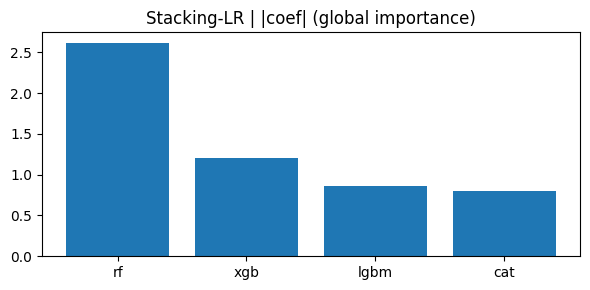

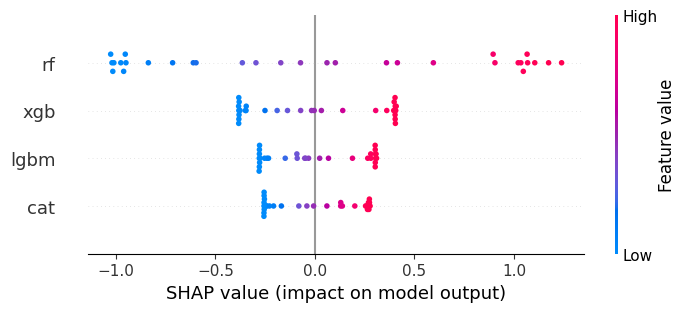

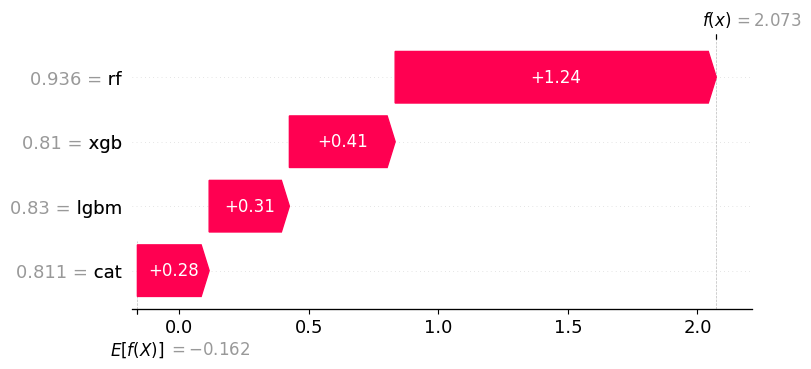

base_model  abs_coef      coef
0         rf  2.613877  2.613877
1        xgb  1.202917  1.202917
2       lgbm  0.857550  0.857550
3        cat  0.797911  0.797911

In [ ]:
# XAI cho Stacking LR (bản Original)
xai_ori_stack = explainable_ai_result(
    X_train, y_train, X_val, y_val, X_test,
    base_models=base_models,
    explain_model="stack",
    sample_idx=0
)


#Insights quan trọng khi đánh giá mức độ đóng góp của mô hình ensemble stacking


##1.   Bar – Stacking-LR

Trục x là |hệ số| của Logistic Regression khi đầu vào là vector xác suất từ các base models (rf, xgb, lgbm, cat).

RF có |coef| lớn nhất ⇒ ở mức toàn cục, khi xác suất của RF tăng, log-odds dự đoán của ensemble thay đổi mạnh nhất.

XGB kế tiếp, rồi LGBM ≈ CatBoost.

Đây là tầm ảnh hưởng toàn cục của từng mô hình trong ensemble, sau hiệu chỉnh xác suất (calibration), nên có thể so sánh được.

##2.  SHAP beeswarm – Stacking-LR

Trục hoành: SHAP value trên đầu ra của meta-LR (thang đo log-odds).

Mỗi “feature” trong hình chính là xác suất dự đoán của một base model.

Các điểm đỏ (giá trị “cao” của base prob) thường nằm phía dương ⇒ khi base model dự đoán xác suất cao, nó kéo ensemble về phía “bệnh”. Điểm xanh (xác suất thấp) kéo về phía “không bệnh”.

Dải điểm của rf rộng và lệch phải hơn ⇒ đóng góp (dương/âm) của RF lên quyết định cuối cùng mạnh và thường xuyên hơn các base còn lại. Điều này nhất quán với bar |coef| ở trên.

##3. Waterfall (local) – Stacking-LR

“E[f(X)]” là baseline log-odds trung bình của meta-model.
Với một bệnh nhân cụ thể (sample_idx), bốn “đặc trưng” (rf/xgb/lgbm/cat) đẩy log-odds tăng lần lượt: rf +1.24, xgb +0.41, … ⇒ giải thích tại sao ca này bị ensemble xếp là “bệnh”.


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

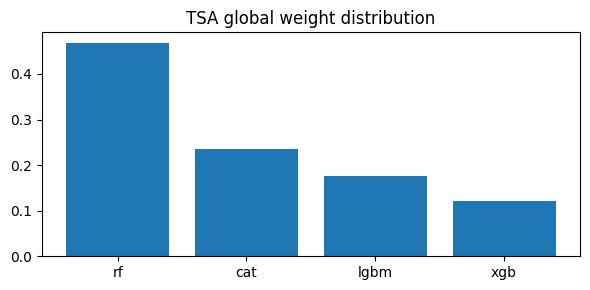

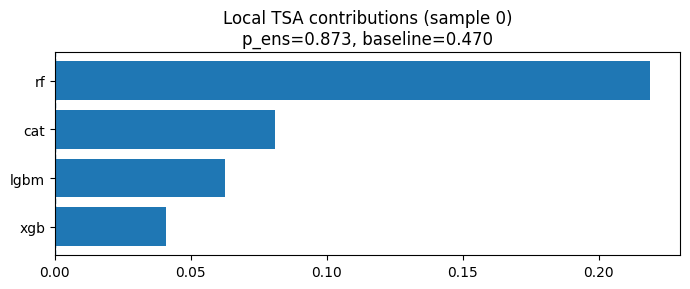

base_model    weight
0         rf  0.467814
1        cat  0.234933
2       lgbm  0.175380
3        xgb  0.121873

base_model  contribution
0        xgb      0.041048
1       lgbm      0.062498
2        cat      0.080893
3         rf      0.218924

In [ ]:
# XAI cho TSA (dùng w_tsa đã tối ưu sẵn lúc evaluate_version)
xai_ori_tsa = explainable_ai_result(
    X_train, y_train, X_val, y_val, X_test,
    base_models=base_models,
    explain_model="tsa",
    w_tsa=ex_ori["w_tsa"],    # lấy từ extras của evaluate_version
    sample_idx=0
)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

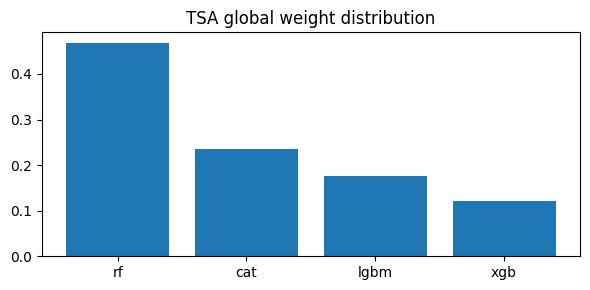

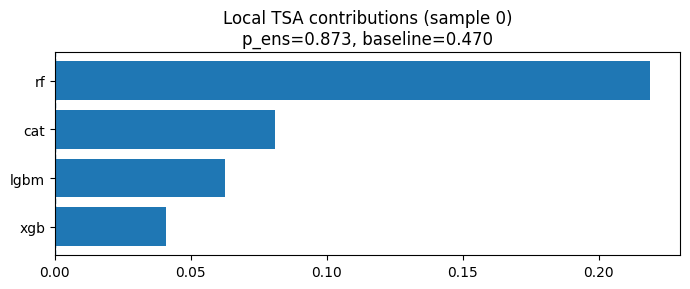

base_model    weight
0         rf  0.467814
1        cat  0.234933
2       lgbm  0.175380
3        xgb  0.121873

base_model  contribution
0        xgb      0.041048
1       lgbm      0.062498
2        cat      0.080893
3         rf      0.218924

In [ ]:
# XAI cho TSA (dùng w_tsa đã tối ưu sẵn lúc evaluate_version)
xai_ori_tsa = explainable_ai_result(
    X_train, y_train, X_val, y_val, X_test,
    base_models=base_models,
    explain_model="tsa",
    w_tsa=ex_ori["w_tsa"],    # lấy từ extras của evaluate_version
    sample_idx=0
)

#Insights quan trọng cho mô hình ensemble tối ưu bằng TSA


1.   Trọng số toàn cục (global) của TSA

Khi tối ưu AUC trên tập validation, TSA học ra một ensemble gần như “RF + CatBoost”, trong đó Random Forest chi phối quyết định. LGBM đóng góp rất nhỏ, XGBoost hầu như bị “tắt tiếng”.

Diễn giải: hoặc RF có khả năng phân biệt tốt nhất (AUC cao nhất/cân bằng bias–variance tốt nhất) trong các base đã hiệu chỉnh xác suất; hoặc đầu ra giữa CatBoost–RF bổ sung nhau (không quá tương quan), còn LGBM/XGB trùng lặp và không thêm lợi ích nên bị đẩy trọng số xuống gần 0 khi tối ưu AUC.

2.   Đóng góp cục bộ (local) cho một mẫu cụ thể

Xét mẫu bệnh nhân đầu tiên:

Baseline = trung bình có trọng số (theo w) của xác suất các base trên toàn bộ test → “mốc” dự đoán điển hình của ensemble.
p_ens = xác suất dự đoán của mô hình ensemble của mẫu đó sau khi cộng các đóng góp.

Trục hoành thể hiện mức độ đóng góp so với baseline. Cụ thể, Ở mẫu #0 này: RF kéo mạnh lên (≈ +0.30), CatBoost kéo thêm (≈ +0.12), LGBM rất nhỏ, XGB ≈ 0 → tổng cộng đẩy từ baseline 0.468 lên 0.893.

Tóm lại, nếu bác sĩ muốn hiểu “ai đã đẩy ca bệnh này sang nguy cơ cao”, câu trả lời là RF là nguồn đóng góp chính, CatBoost hỗ trợ cùng chiều; hai model còn lại không ảnh hưởng đáng kể.

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

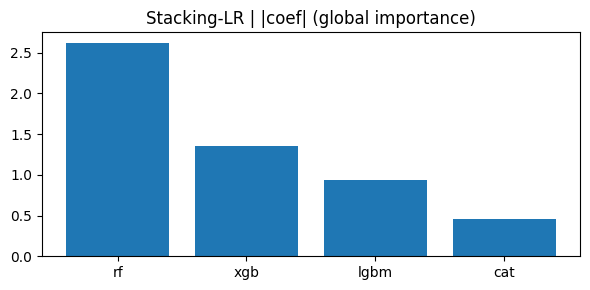

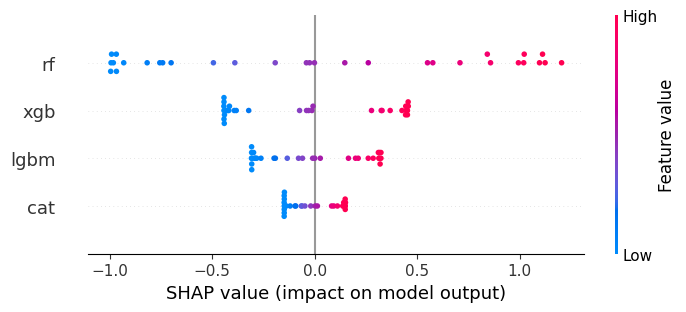

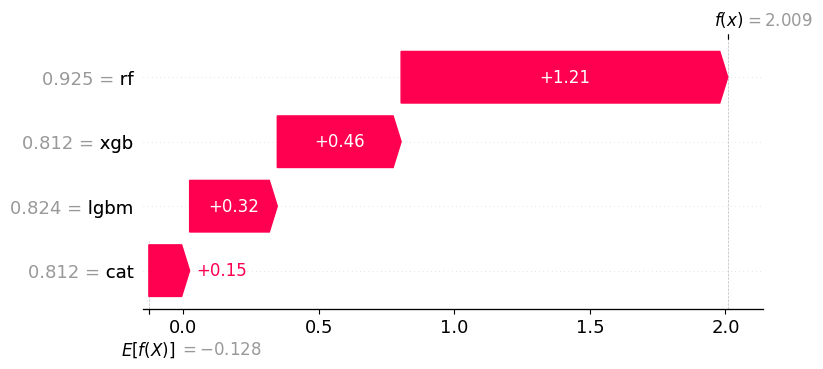

base_model  abs_coef      coef
0         rf  2.617103  2.617103
1        xgb  1.355887  1.355887
2       lgbm  0.939974  0.939974
3        cat  0.457821  0.457821

In [ ]:
# XAI cho Stacking LR (bản Feature Engineering)
xai_ori_stack = explainable_ai_result(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val, X_fe_test,
    base_models=base_models,
    explain_model="stack",
    sample_idx=0
)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

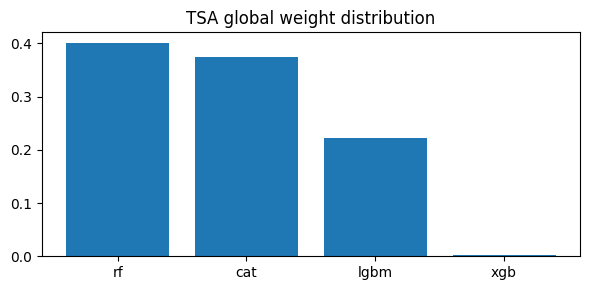

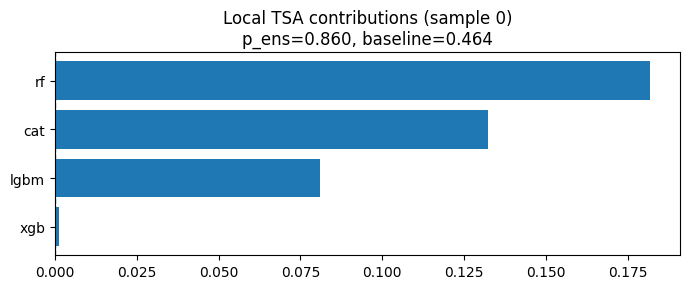

base_model    weight
0         rf  0.400493
1        cat  0.374027
2       lgbm  0.222380
3        xgb  0.003100

base_model  contribution
0        xgb      0.001131
1       lgbm      0.080891
2        cat      0.132322
3         rf      0.181845

In [ ]:
# XAI cho TSA (dùng w_tsa đã tối ưu sẵn lúc evaluate_version)
xai_ori_tsa = explainable_ai_result(
    X_fe_train, y_fe_train, X_fe_val, y_fe_val, X_fe_test,
    base_models=base_models,
    explain_model="tsa",
    w_tsa=ex_fe["w_tsa"],    # lấy từ extras của evaluate_version
    sample_idx=0
)

## Kiểm tra thêm độ nhạy và độ đặc hiệu của PP stacking + TSA trên data FE + DT. Có thể customize để xem các PP còn lại trên các version data còn lại

In [ ]:
def best_f1_threshold(y_val, p_val):
    # dùng precision_recall_curve để có list threshold “hợp lý”
    prec, rec, thr = precision_recall_curve(y_val, p_val)
    # precision_recall_curve trả N thresholds cho N-1 điểm; ghép thêm biên để an toàn
    cand = np.r_[0.0, thr, 1.0]
    f1s = []
    for t in cand:
        yhat = (p_val >= t).astype(int) #Với y_hat > ngưỡng t thì trả về 1 (True - có bệnh)
        f1s.append(f1_score(y_val, yhat))
    idx = int(np.argmax(f1s)) #Lấy ngưỡng cho ra f1 score lớn nhất
    return float(cand[idx]), float(f1s[idx])

In [ ]:
def threshold_at_sensitivity(y_true, y_prob, target_sens=0.95):
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()
    fpr, tpr, thr = roc_curve(y_true, y_prob) # tính false positive rate (1-specificity), true positive rate (recall) và threshold
    idx = np.where(tpr >= float(target_sens))[0]
    if len(idx) == 0:
        best = int(np.argmax(tpr)) #Nếu ko có ngưỡng đạt target, lấy recall max
        return float(thr[best])
    return float(thr[int(idx[0])]) #Nếu có, chọn ngưỡng đầu tiên cũng là ngưỡng thấp nhất

In [ ]:
def get_variant_predictions(X_train, y_train, X_val, y_val, X_test):
    """
    Trả về xác suất VAL/TEST cho 3 phương án: EqualWeights, Stack_LR, Stack_TSA
    """
    P_train_oof, P_val, P_test, _ = train_bases_oof_and_refit(X_train, y_train, X_val, X_test)

    # Equal weights
    p_eq_val  = equal_weight_probs(P_val)
    p_eq_test = equal_weight_probs(P_test)

    # Stack LR
    meta = stack_lr_fit(P_train_oof, y_train)
    p_st_val  = meta.predict_proba(P_val)[:, 1]
    p_st_test = meta.predict_proba(P_test)[:, 1]

    # Stack TSA
    p_tsa_val, p_tsa_test, w_tsa = stack_tsa_predict_auc(P_val, y_val, P_test)

    return {
        "EqualWeights": {"val": p_eq_val,  "test": p_eq_test},
        "Stack_LR":     {"val": p_st_val,  "test": p_st_test},
        "Stack_TSA":    {"val": p_tsa_val, "test": p_tsa_test},
    }


In [ ]:
def show_confusion_metrics(y_true, y_prob, thr=0.5, name="Model"):
    """
    Vẽ confusion matrix và in Sensitivity/Specificity/PPV/NPV tại ngưỡng thr.
    """
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sens = tp / (tp + fn + 1e-12)   # Recall / TPR
    spec = tn / (tn + fp + 1e-12)   # TNR
    ppv  = tp / (tp + fp + 1e-12)   # Precision / PPV
    npv  = tn / (tn + fn + 1e-12)   # NPV

    print(f"\n[{name}] Threshold={thr:.3f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Sensitivity (Recall) = {sens:.4f}")
    print(f"Specificity          = {spec:.4f}")
    print(f"PPV (Precision)      = {ppv:.4f}")
    print(f"NPV                  = {npv:.4f}")

#1. In confusion matrix cho data version có FE và DT

In [ ]:
# ==== Clinical-style evaluation for FE+DT - Stack_TSA ====
preds = get_variant_predictions(X_fe_dt_train, y_fe_dt_train,
                                X_fe_dt_val,   y_fe_dt_val,
                                X_fe_dt_test)

p_val  = preds["Stack_TSA"]["val"]
p_test = preds["Stack_TSA"]["test"]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.08379 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.09295 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.08462 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.08341 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.08651 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.008928571428571397, Global best: 0.008928571428571397, Runtime: 0.07950 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Probl

In [ ]:
# Lấy xác suất test cho Stack_TSA
p_test = preds["Stack_TSA"]["test"]

# Confusion matrix tại ngưỡng 0.5
show_confusion_metrics(y_fe_dt_test, p_test, thr=0.5, name="Stack_TSA @0.5")

# Confusion matrix tại ngưỡng tối ưu F1
thr_f1, _ = best_f1_threshold(y_fe_dt_val, preds["Stack_TSA"]["val"])
show_confusion_metrics(y_fe_dt_test, p_test, thr=thr_f1, name="Stack_TSA @F1_thr")

# Confusion matrix tại ngưỡng Sens >= 0.95 (chọn theo VAL)
thr_sens95 = threshold_at_sensitivity(y_fe_dt_val, preds["Stack_TSA"]["val"], target_sens=0.95)
show_confusion_metrics(y_fe_dt_test, p_test, thr=thr_sens95, name="Stack_TSA @Sens>=0.95")


[Stack_TSA @0.5] Threshold=0.500
Confusion Matrix:
[[14  3]
 [ 1 13]]
Sensitivity (Recall) = 0.9286
Specificity          = 0.8235
PPV (Precision)      = 0.8125
NPV                  = 0.9333

[Stack_TSA @F1_thr] Threshold=0.515
Confusion Matrix:
[[15  2]
 [ 2 12]]
Sensitivity (Recall) = 0.8571
Specificity          = 0.8824
PPV (Precision)      = 0.8571
NPV                  = 0.8824

[Stack_TSA @Sens>=0.95] Threshold=0.515
Confusion Matrix:
[[15  2]
 [ 2 12]]
Sensitivity (Recall) = 0.8571
Specificity          = 0.8824
PPV (Precision)      = 0.8571
NPV                  = 0.8824


#2. In confusion matrix cho data gốc

In [ ]:
# ==== Clinical-style evaluation for Original - Stack_TSA ====
preds = get_variant_predictions(X_train, y_train,
                                X_val,   y_val,
                                X_test)

p_val  = preds["Stack_TSA"]["val"]
p_test = preds["Stack_TSA"]["test"]

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

INFO:mealpy.bio_based.TSA.OriginalTSA:OriginalTSA(epoch=250, pop_size=40)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 1, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.08337 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 2, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.06536 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 3, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.07113 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 4, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.06489 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 5, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.06087 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Problem: P, Epoch: 6, Current best: 0.017857142857142794, Global best: 0.017857142857142794, Runtime: 0.06346 seconds
INFO:mealpy.bio_based.TSA.OriginalTSA:>>>Probl

In [ ]:
p_test = preds["Stack_TSA"]["test"]

# Confusion matrix tại ngưỡng 0.5
show_confusion_metrics(y_test, p_test, thr=0.5, name="Stack_TSA @0.5")

# Confusion matrix tại ngưỡng tối ưu F1
thr_f1, _ = best_f1_threshold(y_val, preds["Stack_TSA"]["val"])
show_confusion_metrics(y_test, p_test, thr=thr_f1, name="Stack_TSA @F1_thr")

# Confusion matrix tại ngưỡng Sens >= 0.95 (chọn theo VAL)
thr_sens95 = threshold_at_sensitivity(y_val, preds["Stack_TSA"]["val"], target_sens=0.95)
show_confusion_metrics(y_test, p_test, thr=thr_sens95, name="Stack_TSA @Sens>=0.95")


[Stack_TSA @0.5] Threshold=0.500
Confusion Matrix:
[[15  2]
 [ 2 12]]
Sensitivity (Recall) = 0.8571
Specificity          = 0.8824
PPV (Precision)      = 0.8571
NPV                  = 0.8824

[Stack_TSA @F1_thr] Threshold=0.612
Confusion Matrix:
[[16  1]
 [ 3 11]]
Sensitivity (Recall) = 0.7857
Specificity          = 0.9412
PPV (Precision)      = 0.9167
NPV                  = 0.8421

[Stack_TSA @Sens>=0.95] Threshold=0.612
Confusion Matrix:
[[16  1]
 [ 3 11]]
Sensitivity (Recall) = 0.7857
Specificity          = 0.9412
PPV (Precision)      = 0.9167
NPV                  = 0.8421


# Phần này Optional

In [ ]:
def show_cls_report(y_true, y_prob, thr=0.5, name="Model"):
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= float(thr)).astype(int)

    print(f"\n[{name}] threshold={thr:.3f}")


    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    # Confusion matrix + chỉ số lâm sàng
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn + 1e-12)   # Recall / TPR
    spec = tn / (tn + fp + 1e-12)   # TNR
    ppv  = tp / (tp + fp + 1e-12)   # Precision / PPV
    npv  = tn / (tn + fn + 1e-12)   # NPV

    print("Confusion matrix:\n", np.array([[tn, fp],[fn, tp]]))
    print(f"Sensitivity (Recall): {sens:.3f}")
    print(f"Specificity         : {spec:.3f}")
    print(f"PPV (Precision)     : {ppv:.3f}")
    print(f"NPV                 : {npv:.3f}")

    # Thêm các metric “không phụ thuộc ngưỡng”
    try:
        print(f"AUC: {roc_auc_score(y_true, y_prob):.3f} | "
              f"AP: {average_precision_score(y_true, y_prob):.3f} | "
              f"LogLoss: {log_loss(y_true, y_prob):.3f} | "
              f"Accuracy@thr: {accuracy_score(y_true, y_pred):.3f}")
    except Exception:
        pass


In [ ]:
# Ngưỡng 0.5
show_cls_report(y_fe_dt_test, p_test, thr=0.5, name="Stack_TSA @0.5")

# Ngưỡng tối ưu F1 theo VAL
thr_f1, _ = best_f1_threshold(y_fe_dt_val, preds["Stack_TSA"]["val"])
show_cls_report(y_fe_dt_test, p_test, thr=thr_f1, name="Stack_TSA @F1_thr")

# Ngưỡng với Sensitivity ≥ 0.95 (tính trên VAL)
thr_sens95 = threshold_at_sensitivity(y_fe_dt_val, preds["Stack_TSA"]["val"], target_sens=0.95)
show_cls_report(y_fe_dt_test, p_test, thr=thr_sens95, name="Stack_TSA @Sens>=0.95")



[Stack_TSA @0.5] threshold=0.500
              precision    recall  f1-score   support

           0      0.875     0.824     0.848        17
           1      0.800     0.857     0.828        14

    accuracy                          0.839        31
   macro avg      0.838     0.840     0.838        31
weighted avg      0.841     0.839     0.839        31

Confusion matrix:
 [[14  3]
 [ 2 12]]
Sensitivity (Recall): 0.857
Specificity         : 0.824
PPV (Precision)     : 0.800
NPV                 : 0.875
AUC: 0.924 | AP: 0.918 | LogLoss: 0.395 | Accuracy@thr: 0.839

[Stack_TSA @F1_thr] threshold=0.496
              precision    recall  f1-score   support

           0      0.933     0.824     0.875        17
           1      0.812     0.929     0.867        14

    accuracy                          0.871        31
   macro avg      0.873     0.876     0.871        31
weighted avg      0.879     0.871     0.871        31

Confusion matrix:
 [[14  3]
 [ 1 13]]
Sensitivity (Recall): 0.9